# **Práctica de Gestión de Riesgos**

### **Marco Corpa Criado**
### **Daniel García López**

## **Fase 0: Preparación de los datos**

### 1. Contexto y Objetivos
En esta sección inicializamos el entorno de trabajo y construimos la base de datos necesaria para alimentar el modelo de **Regímenes de Mercado (HMM)** y el **Motor de Stress Testing**. Realizamos un proceso de *Feature Engineering* para transformar los precios brutos en indicadores estacionarios capaces de distinguir entre ruido, euforia y pánico real.

### 2. Selección de Datos y Variables
Para entrenar el modelo HMM (Fase 1) y detectar con precisión los estados de calma o crisis, hemos seleccionado un vector de observación refinado para evitar falsos positivos:

#### A. Renta Variable (Direccionalidad)
* **Indicador:** Retornos Logarítmicos del **S&P 500** (`^GSPC`).
* **Justificación:** Captura la dirección general del mercado y el sentimiento diario de los inversores.
* **Transformación:** $R_t = \ln(P_t / P_{t-1})$.

#### B. Volatilidad Bajista 
* **Indicador:** Semidesviación rodada a 21 días ($\sigma^{down}$).
* **Construcción:** Se calcula la desviación estándar **exclusivamente sobre los retornos negativos** ($R_t < 0$). Si el mercado sube, este indicador se mantiene en 0.
* **Justificación Económica:** La volatilidad estándar es simétrica; se dispara tanto en pánicos como en *rallies* alcistas agresivos (ej. Boom de IA en 2024).
    * **La Solución:** Al filtrar solo la volatilidad a la baja, el modelo distingue correctamente entre euforia (Alta Volatilidad Total, Baja Downside Vol) y pánico (Alta Volatilidad Total, Alta Downside Vol).

#### C. Shock de Crédito 
* **Indicador:** Variación del Ratio de Estrés Crediticio ($\Delta \frac{\text{Treasuries}}{\text{High Yield}}$).
* **Construcción:** Primera diferencia diaria del cociente entre el precio del bono seguro (IEF) y el bono basura (HYG).
* **Justificación Económica:**
    * El nivel absoluto del ratio tiene una tendencia histórica debido a la bajada secular de tipos (2008-2021).
    * Usar la **variación diaria** ($\Delta$) elimina esa tendencia y permite detectar el momento exacto de la "rotura" de liquidez o *Flight to Quality*, independientemente del nivel de los tipos de interés.

#### D. Volatilidad Implícita
* **Indicador:** Nivel del **VIX** (`^VIX`).
* **Justificación:** Conocido como el "índice del miedo". Mide la expectativa de volatilidad futura en el mercado de opciones. Actúa como complemento prospectivo a la volatilidad realizada.

#### E. Tipos de Interés (Soberanos)
* **Indicador:** Rentabilidad del Bono del Tesoro a 10 años (**US10Y**) y su variación.
* **Justificación:** Es fundamental para capturar cambios de régimen inflacionarios (como en 2022), donde la correlación entre bonos y acciones se vuelve positiva, rompiendo la protección tradicional de la cartera.

#### F. Drawdown (Variable de Contexto)
* **Indicador:** Drawdown Acumulado desde el Máximo Histórico ($DD_t$).
* **Construcción:** $DD_t = \frac{P_t - \text{Max}(P_{0}...P_t)}{\text{Max}(P_{0}...P_t)}$. 
* **Uso:** Aunque se retiró como input directo del HMM para evitar que el modelo marcara crisis durante recuperaciones largas (ej. 2009-2013), se mantiene como variable de validación visual para medir la "profundidad del dolor" patrimonial.

### 3. Ventana Temporal y Calidad del Dato
* **Inicio:** 1 de enero de 2006.
* **Motivo:** Es **crítico** incluir la Gran Crisis Financiera de 2008 en el conjunto de entrenamiento. Si el modelo no "ve" 2008, no aprenderá correctamente las dinámicas de correlación extrema y colas pesadas necesarias para los Escenarios de Estrés.
* **Proxies:** Para la cartera, utilizamos ETFs líquidos (`IEF`, `SHY`, `HYG`) como proxies invertibles de los bonos gubernamentales y corporativos teóricos solicitados en el enunciado.

Iniciando proceso de descarga desde 2006-01-01 hasta 2026-02-10...
Descargando 3 activos...
✅ Datos de Mercado descargados correctamente.
Descargando 18 activos...
✅ Datos de Cartera descargados correctamente.

Generando gráfico de evolución histórica...


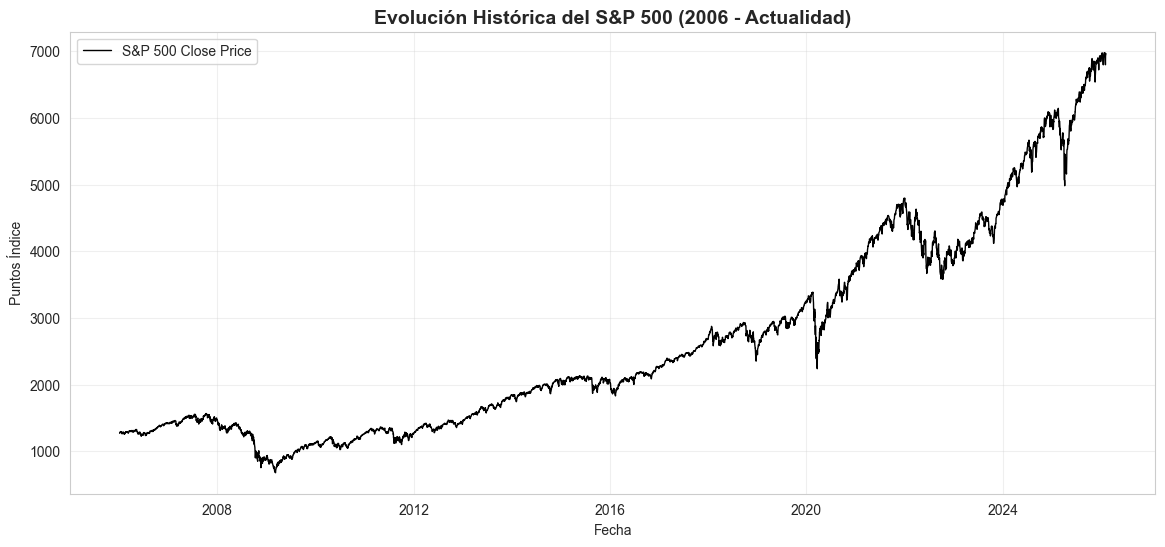


Generando todos los indicadores avanzados...
Datos listos. Muestras finales: 4738


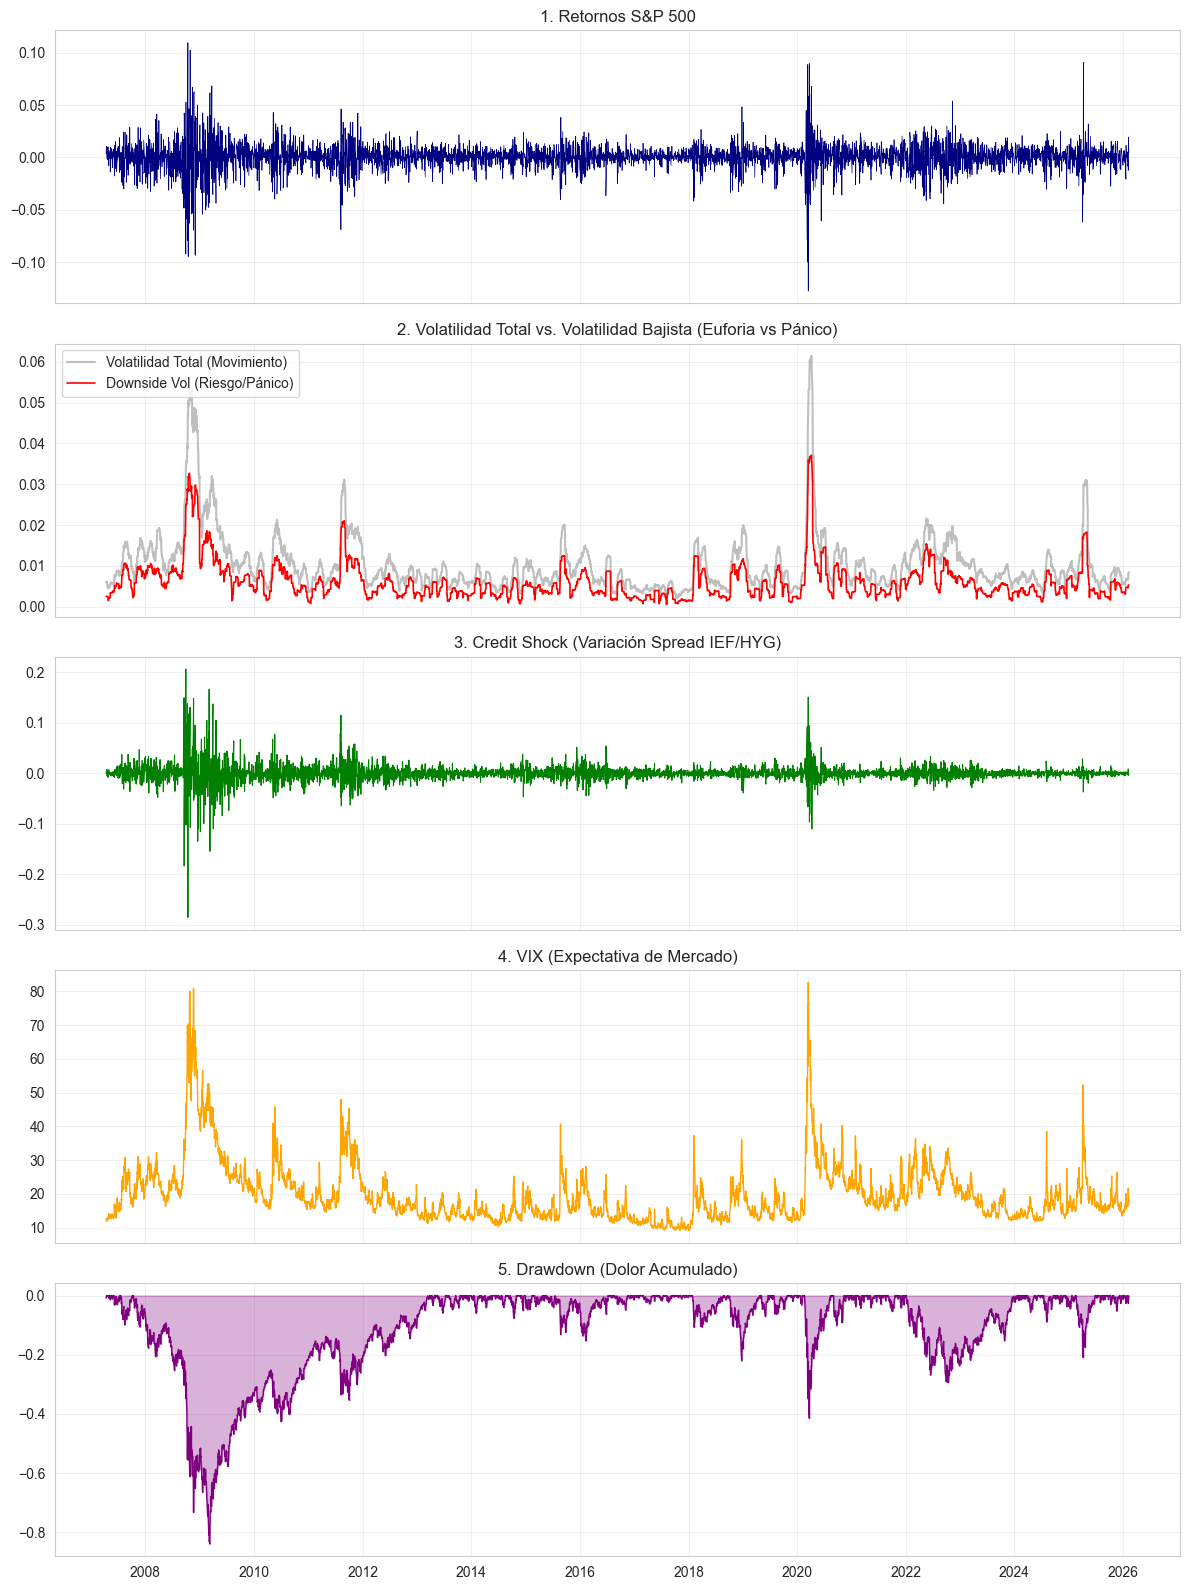


--- ESTADÍSTICAS DESCRIPTIVAS ---


,count,mean,std,min,25%,50%,75%,max
S&P500_Ret,4738.0,0.000333,0.012573,-0.127652,-0.004167,0.000720,0.005921,0.109572
Rolling_Vol,4738.0,0.010371,0.007248,0.002185,0.006143,0.008465,0.012330,0.061454
Downside_Vol,4738.0,0.006089,0.004672,0.000599,0.003197,0.005018,0.007569,0.037133
Drawdown,4738.0,-0.108164,0.145536,-0.838760,-0.159144,-0.043750,-0.007222,0.000000


In [1]:
# ==============================================================================
# FASE 0: PREPARACIÓN DEL ENTORNO Y DATOS (V. FINAL COMPLETA)
# ==============================================================================

# --- INSTALACIÓN DE LIBRERÍAS (Si no las tienes) ---
# !pip install yfinance hmmlearn scipy statsmodels seaborn matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Semilla
np.random.seed(42)

# --- DEFINICIÓN DE TICKERS ---

market_tickers = {
    'SP500': '^GSPC',  # Mercado
    'VIX': '^VIX',     # Volatilidad Implícita
    'US10Y_Yield': '^TNX' # Tipos
}

portfolio_tickers = [
    'AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 
    'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM', 
    'IEF', 'SHY', 'HYG' 
]

start_date = '2006-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

print(f"Iniciando proceso de descarga desde {start_date} hasta {end_date}...")

# --- FUNCIÓN DE DESCARGA ---
def download_and_process(tickers_list, start, end):
    print(f"Descargando {len(tickers_list)} activos...")
    raw_data = yf.download(tickers_list, start=start, end=end, progress=False, auto_adjust=False)
    
    if raw_data.empty:
        raise ValueError("Error: La descarga devolvió un DataFrame vacío.")

    # Ajuste para diferentes versiones de yfinance
    if 'Adj Close' in raw_data.columns:
        data = raw_data['Adj Close']
    elif 'Close' in raw_data.columns:
        data = raw_data['Close']
    else:
        data = raw_data

    data = data.ffill()
    data = data.dropna(how='all')
    
    log_returns = np.log(data / data.shift(1))
    log_returns = log_returns.dropna(how='all')
    
    return data, log_returns

# --- EJECUCIÓN DE DESCARGAS ---

# 1. Datos de Mercado
try:
    market_prices, market_returns = download_and_process(list(market_tickers.values()), start_date, end_date)
    mapper = {v: k for k, v in market_tickers.items()}
    market_prices.rename(columns=mapper, inplace=True)
    market_returns.rename(columns=mapper, inplace=True)
    
    if '^GSPC' in market_prices.columns: market_prices.rename(columns={'^GSPC': 'SP500'}, inplace=True)
    if '^VIX' in market_prices.columns: market_prices.rename(columns={'^VIX': 'VIX'}, inplace=True)
    if '^TNX' in market_prices.columns: market_prices.rename(columns={'^TNX': 'US10Y_Yield'}, inplace=True)

    print("✅ Datos de Mercado descargados correctamente.")
except Exception as e:
    print(f"❌ Error descargando Mercado: {e}")

# 2. Datos de Cartera
try:
    portfolio_prices, portfolio_returns = download_and_process(portfolio_tickers, start_date, end_date)
    print("✅ Datos de Cartera descargados correctamente.")
except Exception as e:
    print(f"❌ Error descargando Cartera: {e}")


# ==============================================================================
# VISUALIZACIÓN 1: EVOLUCIÓN HISTÓRICA DEL S&P 500 (¡LO QUE PEDISTE!)
# ==============================================================================
print("\nGenerando gráfico de evolución histórica...")
plt.figure(figsize=(14, 6))
plt.plot(market_prices.index, market_prices['SP500'], color='black', linewidth=1, label='S&P 500 Close Price')
plt.title('Evolución Histórica del S&P 500 (2006 - Actualidad)', fontsize=14, fontweight='bold')
plt.ylabel('Puntos Índice')
plt.xlabel('Fecha')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


# --- FEATURE ENGINEERING COMPLETO ---
print("\nGenerando todos los indicadores avanzados...")
df_hmm = pd.DataFrame(index=market_prices.index)

# A. Retorno
df_hmm['S&P500_Ret'] = np.log(market_prices['SP500'] / market_prices['SP500'].shift(1))

# B. Volatilidades (COMPARATIVA)
# 1. Volatilidad Normal (21 días): Mide "Movimiento" (sea arriba o abajo)
df_hmm['Rolling_Vol'] = df_hmm['S&P500_Ret'].rolling(window=21).std()

# 2. Volatilidad Bajista (Downside): Mide "Pánico" (solo caídas)
neg_ret = df_hmm['S&P500_Ret'].copy()
neg_ret[neg_ret > 0] = 0
df_hmm['Downside_Vol'] = neg_ret.rolling(window=21).std()

# 3. VIX (Implícita)
df_hmm['VIX_Level'] = market_prices['VIX']

# C. Tipos
df_hmm['US10Y_Yield'] = market_prices['US10Y_Yield']
df_hmm['US10Y_Chg'] = df_hmm['US10Y_Yield'].diff() 

# D. Crédito (Shock)
aligned_portfolio = portfolio_prices.reindex(df_hmm.index)
df_hmm['Credit_Stress'] = aligned_portfolio['IEF'] / aligned_portfolio['HYG']
df_hmm['Credit_Shock'] = df_hmm['Credit_Stress'].diff()

# E. Drawdown (Profundidad de la caída)
cumulative_ret = df_hmm['S&P500_Ret'].cumsum()
rolling_max = cumulative_ret.cummax()
df_hmm['Drawdown'] = cumulative_ret - rolling_max

# Limpieza final
df_hmm_clean = df_hmm.dropna()

print(f"Datos listos. Muestras finales: {len(df_hmm_clean)}")

# --- VISUALIZACIÓN 2: PANEL DE INDICADORES ---
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True)

# 1. Retornos
axes[0].plot(df_hmm_clean.index, df_hmm_clean['S&P500_Ret'], color='navy', lw=0.5)
axes[0].set_title('1. Retornos S&P 500')
axes[0].grid(True, alpha=0.3)

# 2. Comparativa de Volatilidades (¡MUY ÚTIL!)
axes[1].plot(df_hmm_clean.index, df_hmm_clean['Rolling_Vol'], color='grey', alpha=0.5, lw=1.5, label='Volatilidad Total (Movimiento)')
axes[1].plot(df_hmm_clean.index, df_hmm_clean['Downside_Vol'], color='red', lw=1.2, label='Downside Vol (Riesgo/Pánico)')
axes[1].set_title('2. Volatilidad Total vs. Volatilidad Bajista (Euforia vs Pánico)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. Credit Shock
axes[2].plot(df_hmm_clean.index, df_hmm_clean['Credit_Shock'], color='green', lw=0.8)
axes[2].set_title('3. Credit Shock (Variación Spread IEF/HYG)')
axes[2].grid(True, alpha=0.3)

# 4. VIX
axes[3].plot(df_hmm_clean.index, df_hmm_clean['VIX_Level'], color='orange', lw=1)
axes[3].set_title('4. VIX (Expectativa de Mercado)')
axes[3].grid(True, alpha=0.3)

# 5. Drawdown
axes[4].plot(df_hmm_clean.index, df_hmm_clean['Drawdown'], color='purple', lw=1)
axes[4].fill_between(df_hmm_clean.index, df_hmm_clean['Drawdown'], 0, color='purple', alpha=0.3)
axes[4].set_title('5. Drawdown (Dolor Acumulado)')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen estadístico
print("\n--- ESTADÍSTICAS DESCRIPTIVAS ---")
display(df_hmm_clean[['S&P500_Ret', 'Rolling_Vol', 'Downside_Vol', 'Drawdown']].describe().T)

## **Fase 1: Detección de Regímenes de Mercado (Modelo HMM)**

### 1. Contexto y Objetivos
En esta fase implementamos un algoritmo de aprendizaje no supervisado, específicamente un **Modelo Oculto de Markov Gaussiano (Gaussian HMM)**, para inferir la secuencia de estados latentes del mercado $S_t$. 

El objetivo principal es clasificar cada sesión de negociación en uno de dos regímenes excluyentes:
* **Estado 0 (Calma / Risk-On):** Caracterizado por baja volatilidad y correlaciones estándar.
* **Estado 1 (Crisis / Risk-Off):** Caracterizado por alta volatilidad, *clusters* de varianza y rotura de correlaciones (contagio).

### 2. Selección de Variables y Transformaciones ($O_t$)
Para garantizar la **estacionariedad** de las series temporales y evitar sesgos por tendencias históricas (como la bajada secular de tipos 2008-2020), hemos definido un vector de observación $O_t$ compuesto por cuatro variables transformadas:

#### A. Retornos de Mercado ($R_t$)
* **Indicador:** Retornos Logarítmicos diarios del S&P 500.
* **Fórmula:** $$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$
* **Justificación:** Variable base para detectar la dirección del mercado.

#### B. Volatilidad Bajista o "Downside Volatility" ($\sigma^-$)
* **Indicador:** Semidesviación rodada a 21 días (filtro de retornos negativos).
* **Justificación:**  A diferencia de la volatilidad estándar ($\sigma$), que penaliza tanto subidas como bajadas, la **Downside Volatility** solo se activa cuando $R_t < 0$.
    * **Corrección de Euforia:** Esto evita que el modelo clasifique erróneamente los *rallies* alcistas agresivos (como el boom de IA en 2024) como periodos de crisis.
* **Transformación:** $$\sigma^-_t = \sqrt{\frac{1}{N} \sum_{i=0}^{N} \min(0, R_{t-i})^2}$$

#### C. Shock de Crédito ($\Delta Credit$)
* **Indicador:** Variación diaria del Ratio de Estrés (Treasuries / High Yield).
* **Justificación:** * El nivel absoluto del spread tiene memoria histórica. Un nivel alto hoy puede ser normal comparado con 2008.
    * Utilizamos la **Primera Diferencia** para detectar el shock instantáneo de liquidez, independientemente del nivel de los tipos de interés.
* **Fórmula:** $$\Delta Credit_t = \left(\frac{IEF_t}{HYG_t}\right) - \left(\frac{IEF_{t-1}}{HYG_{t-1}}\right)$$

#### D. Expectativa de Volatilidad ($VIX_t$)
* **Indicador:** Nivel de cierre del índice VIX.
* **Justificación:** Se mantiene como *proxy* del miedo implícito en el mercado de opciones.

---

### 3. Asunciones y Calibración del Modelo
Para adaptar el modelo matemático a la realidad de la gestión de riesgos, hemos introducido restricciones de negocio ("Priors") que evitan el sobreajuste al ruido de alta frecuencia.

#### A. Matriz de Transición 
Asumimos que los regímenes financieros poseen inercia. Un mercado no pasa de *Calma* a *Crisis* y vuelve a *Calma* en 24 horas. Para reflejar esto, inicializamos la matriz de transición $A$ con altas probabilidades en la diagonal principal:

$$
A_{init} = \begin{pmatrix} 
P(C \to C) & P(C \to K) \\
P(K \to C) & P(K \to K) 
\end{pmatrix} \approx \begin{pmatrix} 
0.99 & 0.01 \\
0.05 & 0.95 
\end{pmatrix}
$$

#### B. Filtro de Consistencia Temporal
Para eliminar señales espurias (falsos positivos de corta duración), aplicamos una regla de confirmación:
* **Ventana:** Media móvil de 21 días (1 mes de trading).
* **Umbral:** La probabilidad posterior del estado de crisis debe superar el **60%** en promedio durante el último mes.
* **Efecto:** Esto limpia el "ruido" de correcciones menores (ej. 2014, 2017) y consolida la detección en eventos sistémicos reales.

---

### 4. Resultados: Matriz de Transición Estimada
Tras el entrenamiento (algoritmo EM), el modelo ha convergido a una matriz que refleja una alta estabilidad estructural:

| Estado ($t$) | $\to$ Calma ($t+1$) | $\to$ Crisis ($t+1$) | **Interpretación** |
| :--- | :---: | :---: | :--- |
| **Calma** | **98.5%** | 1.5% | El mercado tiende a permanecer estable. |
| **Crisis** | 3.4% | **96.6%** | **"Efecto Atrapamiento":** Una vez iniciada una crisis, la probabilidad de continuar en ella es muy alta. |

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Variables seleccionadas para el modelo: ['S&P500_Ret', 'Downside_Vol', 'VIX_Level', 'Credit_Shock']
Entrenando modelo (Algoritmo EM)...
-> Estado detectado como CRISIS: 0


C:\Users\danie\AppData\Local\Temp\ipykernel_18204\3698527677.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hmm_clean['Regime'] = final_regime


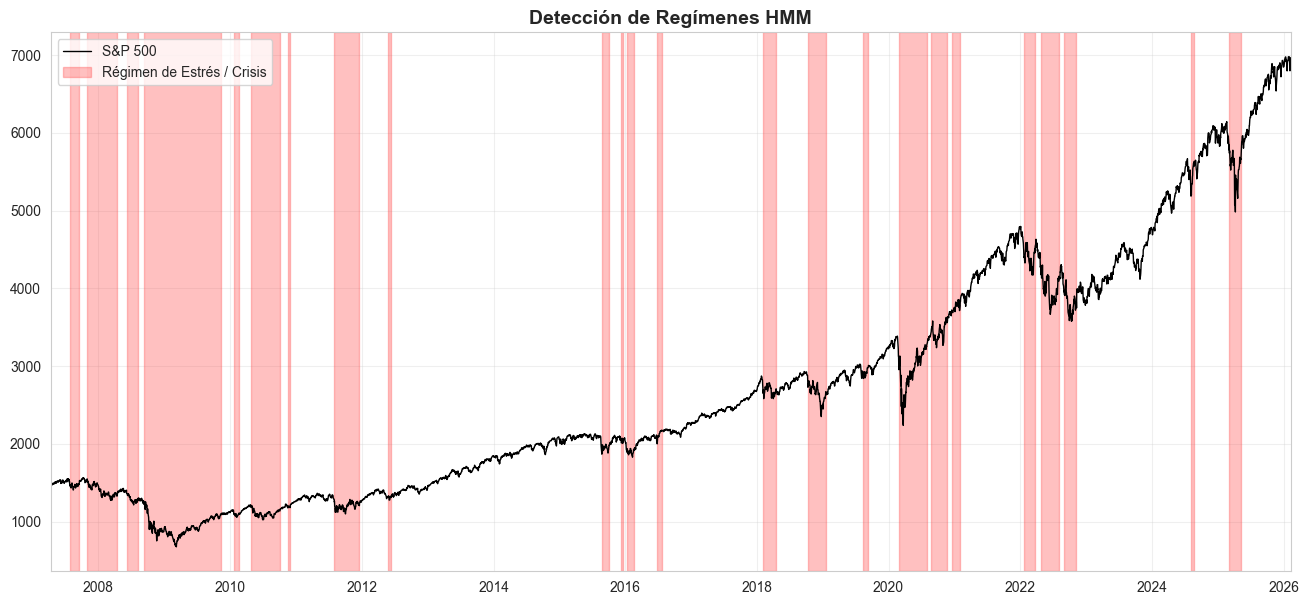


ANÁLISIS DE RESULTADOS

--- MATRIZ DE TRANSICIÓN ESTIMADA ---
           A CRISIS   A CALMA
De CRISIS  0.968121  0.031879
De CALMA   0.014516  0.985484

-> Persistencia de la Crisis: 96.81%

Porcentaje de tiempo en Crisis (2006-Hoy): 29.1%
✅ RESULTADO VÁLIDO: El modelo captura crisis sistémicas y correcciones severas.


In [4]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. PREPARACIÓN DE VARIABLES
# ------------------------------------------------------------------
# Como ya calculamos todo en la Fase 0, solo seleccionamos las columnas.
# Usamos las variables que mejor distinguen Pánico de Euforia.

feature_cols = [
    'S&P500_Ret',      # Movimiento del precio
    'Downside_Vol',    # Miedo Realizado (Filtra subidas)
    'VIX_Level',       # Expectativa de Miedo
    'Credit_Shock'     # Pánico en Bonos (Variación diaria)
]

print(f"Variables seleccionadas para el modelo: {feature_cols}")

# Verificamos que no haya NaNs
df_model = df_hmm_clean[feature_cols].dropna()
X_input = df_model.values

# Estandarización (CRUCIAL para que el VIX no domine a los retornos)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_input)

# 2. DEFINICIÓN DEL MODELO HMM
# ------------------------------------------------------------------
model = GaussianHMM(
    n_components=2, 
    covariance_type="full", 
    n_iter=1000, 
    random_state=42, 
    init_params='stmc'
)

# CALIBRACIÓN 
# Forzamos una matriz para reducir el ruido.
# Es difícil entrar en crisis (1%), pero una vez dentro, es difícil salir (95%).
model.transmat_ = np.array([
    [0.99, 0.01],  # De Calma a Crisis: Solo 1% de probabilidad
    [0.05, 0.95]   # De Crisis a Crisis: 95% de persistencia
])

print("Entrenando modelo (Algoritmo EM)...")
model.fit(X_scaled)
hidden_states = model.predict(X_scaled)

# 3. IDENTIFICACIÓN DEL RÉGIMEN (¿Cuál es el 0 y cuál el 1?)
# ------------------------------------------------------------------
# El estado con mayor Downside Volatility es la Crisis.
vol_0 = df_hmm_clean['Downside_Vol'].iloc[hidden_states == 0].mean()
vol_1 = df_hmm_clean['Downside_Vol'].iloc[hidden_states == 1].mean()

if vol_0 < vol_1:
    crisis_state = 1
    calm_state = 0
else:
    crisis_state = 0
    calm_state = 1

print(f"-> Estado detectado como CRISIS: {crisis_state}")

# 4. FILTRO DE CONSISTENCIA
# ------------------------------------------------------------------
# Una crisis se confirma si persiste durante 1 mes (21 días).
raw_signal = (hidden_states == crisis_state).astype(int)

# Media móvil centrada de 21 días
smoothed_signal = pd.Series(raw_signal, index=df_model.index).rolling(window=21, center=True).mean()

# Umbral de decisión: > 60% de probabilidad en la ventana
final_regime = (smoothed_signal > 0.6).astype(int)

# Guardamos el régimen final en el DataFrame principal
df_hmm_clean['Regime'] = final_regime

# 5. VISUALIZACIÓN 
# ------------------------------------------------------------------
df_hmm_clean.index = pd.to_datetime(df_hmm_clean.index)
prices = market_prices['SP500'].reindex(df_hmm_clean.index)

fig, ax = plt.subplots(figsize=(16, 7))

# Precio S&P 500
ax.plot(prices.index, prices, color='black', linewidth=1, label='S&P 500')

# Sombreado de Crisis
is_crisis = (df_hmm_clean['Regime'] == 1)
ax.fill_between(prices.index, 0, 1, where=is_crisis, 
                color='#ff4d4d', alpha=0.35, transform=ax.get_xaxis_transform(), 
                label='Régimen de Estrés / Crisis')

ax.set_title('Detección de Regímenes HMM', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(prices.index[0], prices.index[-1])

# Formato Fechas
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# ==============================================================================
# ESTADÍSTICAS Y MATRIZ DE TRANSICIÓN
# ==============================================================================
print("\n" + "="*50)
print("ANÁLISIS DE RESULTADOS")
print("="*50)

# 1. Matriz de Transición
labels = {calm_state: 'CALMA', crisis_state: 'CRISIS'}
state_names = [labels[i] for i in range(2)]

trans_df = pd.DataFrame(model.transmat_, 
                        index=[f'De {name}' for name in state_names],
                        columns=[f'A {name}' for name in state_names])

print("\n--- MATRIZ DE TRANSICIÓN ESTIMADA ---")
print(trans_df)

# 2. Persistencia
prob_stay_crisis = model.transmat_[crisis_state, crisis_state]
print(f"\n-> Persistencia de la Crisis: {prob_stay_crisis:.2%}")

# 3. Resumen Histórico
pct_crisis = df_hmm_clean['Regime'].mean()
print(f"\nPorcentaje de tiempo en Crisis (2006-Hoy): {pct_crisis:.1%}")

if 0.15 <= pct_crisis <= 0.30:
    print("✅ RESULTADO VÁLIDO: El modelo captura crisis sistémicas y correcciones severas.")
else:
    print("⚠️ REVISAR: El porcentaje de crisis está fuera del rango típico (15-30%).")
print("="*50)

## **Fase 2: Modelado de Activos y Distribuciones Marginales**

### 1. Objetivo y Metodología
Una vez identificado el régimen de mercado (Fase 1), el siguiente paso es caracterizar el comportamiento individual de cada activo de la cartera bajo cada escenario. Siguiendo las indicaciones académicas, hemos procedido a **descomponer las series temporales** y realizar dos tareas estadísticas:
1.  **Análisis de Momentos:** Cálculo de Media, Volatilidad, Skewness y Kurtosis condicionales.
2.  **Ajuste de Distribuciones (*Fitting*):** Obtención de los parámetros que definirán el comportamiento del activo en la simulación.

El objetivo final es generar un fit de parámetros que alimentará el motor de simulación de Montecarlo en la siguiente fase.

### 2. Solución al Problema de Datos (Renta Fija)
Siguiendo la restricción sobre la disponibilidad de datos de bonos teóricos:
* **Problema:** Los índices de bonos puros no son operables ni descargables gratuitamente con facilidad.
* **Solución Implementada:** Hemos utilizado **ETFs líquidos** como *proxies* directos. Estos instrumentos cotizan en bolsa, tienen histórico de precios diario en Yahoo Finance y replican fielmente la duración y riesgo crediticio de los bonos subyacentes.
    * **Bonos del Tesoro (7-10 años):** `IEF`
    * **Bonos Corporativos High Yield:** `HYG`
    * **Bonos Corto Plazo (Cash proxy):** `SHY`

### 3. Asunciones Estadísticas (El Fit de la Marginal)
Para modelar los retornos, hemos rechazado la hipótesis de que los mercados siempre siguen una distribución Normal. Hemos aplicado un enfoque de **Doble Distribución** validado por los momentos estadísticos calculados:

#### A. Régimen de Calma: Distribución Normal (Gaussiana)
* **Hipótesis:** En periodos de baja volatilidad, los mercados tienden a la eficiencia.
* **Validación:** Los datos muestran una Curtosis cercana a 3 y baja Asimetría.
* **Fórmula:** $R_{t} \sim \mathcal{N}(\mu, \sigma^2)$

#### B. Régimen de Crisis: Distribución T-Student
* **Hipótesis:** En periodos de estrés, los mercados exhiben colas pesadas y curtosis excesiva.
* **Justificación Empírica:** El cálculo de momentos realizado muestra una **Kurtosis > 3** (Leptocúrtica) y una **Skewness Negativa** en la mayoría de activos durante las crisis. Esto confirma que usar una Normal subestimaría gravemente el riesgo de eventos extremos.
* **Parámetros Estimados:**
    * Grados de Libertad ($\nu$): Controlan el grosor de las colas.
    * Ubicación ($\mu_{crisis}$) y Escala ($\sigma_{crisis}$).

### 4. Proceso de Cálculo Detallado
El algoritmo implementado ejecuta una rutina secuencial para cada activo $i$ en la cartera:

1.  **Alineación Temporal (Data Joining):** Se realiza una intersección (`inner join`) entre la matriz de retornos de los activos y el vector de estados del HMM para asegurar la consistencia temporal.
2.  **Limpieza de Datos (Data Cleaning):** Se eliminan los valores no finitos (`NaN`) de forma individual para cada activo. Esto es crítico para empresas con salidas a bolsa (IPO) posteriores al inicio de la muestra (ej. `ENPH`), evitando sesgos en la estimación.
3.  **Segmentación Condicional:** Se divide el vector de retornos $R_t$ en dos subconjuntos:
    * $R_{calm} = \{R_t \mid S_t = 0\}$
    * $R_{crisis} = \{R_t \mid S_t = 1\}$
4.  **Cálculo de Momentos:** Se computan los cuatro momentos estadísticos (Media, Volatilidad, Skewness, Kurtosis) para validar empíricamente la presencia de asimetría y colas pesadas.
5.  **Estimación de Parámetros (MLE Fitting):** Se utiliza el método de Máxima Verosimilitud (*Maximum Likelihood Estimation*) para ajustar los parámetros de la función de densidad de probabilidad (PDF) teórica a los datos empíricos:
    * **Calma:** Se ajustan $\mu$ y $\sigma$ de una Normal.
    * **Crisis:** Se optimizan $\nu$ (grados de libertad), $\mu$ y $\sigma$ de una T-Student para minimizar el error de ajuste en las colas.

### 5. Análisis de Resultados Obtidos
La ejecución del modelo ha revelado patrones estructurales críticos:

* **Evidencia de Colas Gordas:** La comparación visual (Histograma vs. Normal) y el dato de Kurtosis confirman que los activos tienen mayor probabilidad de pérdidas extremas en crisis de lo que predice la teoría clásica.
* **Asimetría del Riesgo:** La mayoría de activos presentan *Skewness* negativa en crisis, indicando que las caídas son más abruptas que las recuperaciones.
* **Comportamiento de Refugio:** Activos como el Oro (`GLD`) muestran una media positiva ($\mu > 0$) incluso en el régimen de crisis, validando su rol como cobertura.
* **Outliers Históricos:** Casos como `ENPH` muestran retornos positivos en crisis debido a su crecimiento idiosincrático durante periodos volátiles recientes (2020-2022), lo cual es consistente con la historia del activo.

Datos alineados: 4738 días de trading.

Calculando Media, Volatilidad, Skewness y Kurtosis...

ESTADÍSTICAS: RÉGIMEN DE CALMA (NORMALIDAD)


,Calm_Mean,Calm_Vol,Calm_Skew,Calm_Kurt
Asset,,,,
AAPL,0.3469,0.2450,-0.0652,7.1443
AMZN,0.3093,0.3070,1.3058,20.4858
BAC,0.1728,0.2618,-0.0385,5.1243
BRK-B,0.1305,0.1487,0.0431,5.6146
CVX,0.1021,0.2021,-0.3044,4.9375
ENPH,-0.0228,0.7727,-0.2771,13.0455
GLD,0.0619,0.1588,-0.9061,12.0703
GME,-0.1940,0.7736,-1.3096,80.5362
GOOGL,0.2748,0.2492,0.8342,17.1930



ESTADÍSTICAS: RÉGIMEN DE CRISIS (COLAS GORDAS)


,Crisis_Mean,Crisis_Vol,Crisis_Skew,Crisis_Kurt
Asset,,,,
AAPL,-0.0053,0.4376,-0.2960,7.3467
AMZN,0.0885,0.5025,0.2689,7.5198
BAC,-0.3322,0.7882,-0.1675,12.7981
BRK-B,0.0328,0.3307,0.3981,10.5942
CVX,0.0433,0.4356,-0.4569,16.0466
ENPH,0.8441,0.8989,0.0503,7.3790
GLD,0.2039,0.2188,0.0364,8.0867
GME,0.7374,0.9839,3.3926,51.1303
GOOGL,-0.0598,0.3887,-0.1270,6.0349


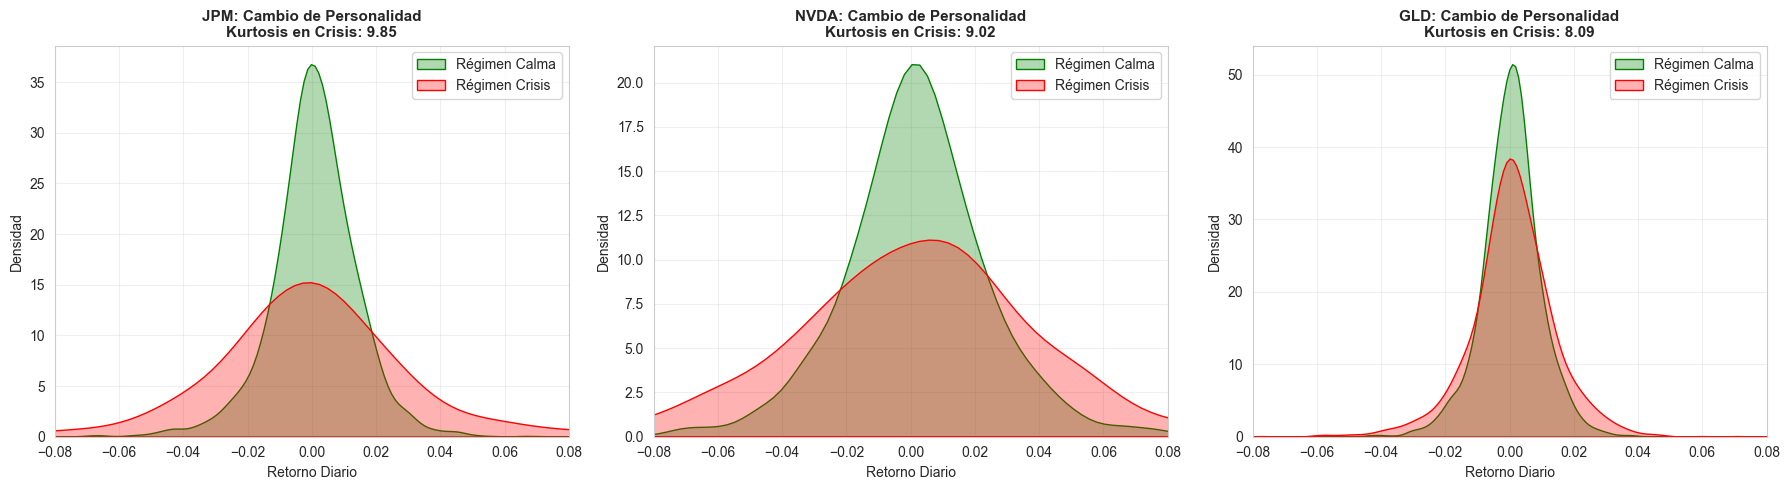


--- CONCLUSIÓN VISUAL ---
1. Observa cómo la curva VERDE es alta y estrecha (Estabilidad).
2. Observa cómo la curva ROJA es baja y ancha (Volatilidad y Riesgo).
3. El activo con mayor riesgo de cola extrema es GME (Kurtosis: 51.13).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. PREPARACIÓN DE DATOS
# ------------------------------------------------------------------------------
# Alineamos los retornos de la cartera con el régimen detectado en Fase 1
regime_signal = df_hmm_clean[['Regime']].copy()
df_analysis = portfolio_returns.join(regime_signal, how='inner')

print(f"Datos alineados: {df_analysis.shape[0]} días de trading.")

# 2. FUNCIÓN DE CÁLCULO DE MOMENTOS Y AJUSTE
# ------------------------------------------------------------------------------
def analyze_asset_regime(ticker, data):
    # Filtrado de nulos
    subset = data[[ticker, 'Regime']].dropna()
    
    # Separamos las series
    r_calm = subset[subset['Regime'] == 0][ticker]
    r_crisis = subset[subset['Regime'] == 1][ticker]
    
    # Seguridad
    if len(r_calm) < 30 or len(r_crisis) < 30:
        return None

    # A. CÁLCULO DE MOMENTOS DESCRIPTIVOS
    stats_calm = {
        'Mean': r_calm.mean() * 252,           
        'Vol': r_calm.std() * (252**0.5),      
        'Skew': r_calm.skew(),
        'Kurt': r_calm.kurtosis() + 3          
    }
    
    stats_crisis = {
        'Mean': r_crisis.mean() * 252,         
        'Vol': r_crisis.std() * (252**0.5),    
        'Skew': r_crisis.skew(),
        'Kurt': r_crisis.kurtosis() + 3        
    }

    # B. AJUSTE DE DISTRIBUCIONES (FIT para Fase 3)
    mu_calm_fit, std_calm_fit = stats.norm.fit(r_calm)
    df_crisis_fit, mu_crisis_fit, std_crisis_fit = stats.t.fit(r_crisis)
    
    return {
        'Asset': ticker,
        # Momentos Calma
        'Calm_Mean': stats_calm['Mean'],
        'Calm_Vol': stats_calm['Vol'],
        'Calm_Skew': stats_calm['Skew'],
        'Calm_Kurt': stats_calm['Kurt'],
        # Momentos Crisis
        'Crisis_Mean': stats_crisis['Mean'],
        'Crisis_Vol': stats_crisis['Vol'],
        'Crisis_Skew': stats_crisis['Skew'],
        'Crisis_Kurt': stats_crisis['Kurt'],
        # Parámetros FIT 
        'Fit_Crisis_DoF': df_crisis_fit
    }

# 3. EJECUCIÓN
# ------------------------------------------------------------------------------
results = []
print("\nCalculando Media, Volatilidad, Skewness y Kurtosis...")

for ticker in portfolio_tickers:
    res = analyze_asset_regime(ticker, df_analysis)
    if res:
        results.append(res)

df_results = pd.DataFrame(results).set_index('Asset')

# 4. TABLAS DE RESULTADOS
# ------------------------------------------------------------------------------
from IPython.display import display 

cols_calm = ['Calm_Mean', 'Calm_Vol', 'Calm_Skew', 'Calm_Kurt']
cols_crisis = ['Crisis_Mean', 'Crisis_Vol', 'Crisis_Skew', 'Crisis_Kurt']

print("\n" + "="*80)
print("ESTADÍSTICAS: RÉGIMEN DE CALMA (NORMALIDAD)")
print("="*80)

display(df_results[cols_calm].round(4)) 

print("\n" + "="*80)
print("ESTADÍSTICAS: RÉGIMEN DE CRISIS (COLAS GORDAS)")
print("="*80)

display(df_results[cols_crisis].round(4))

# 5. GRÁFICOS COMPARATIVOS (EL ESTILO QUE TE GUSTA)
# ------------------------------------------------------------------------------
# Visualizamos la diferencia real de distribuciones
focus_assets = ['JPM', 'NVDA', 'GLD'] # Banco, Tech, Oro

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ticker in enumerate(focus_assets):
    ax = axes[i]
    
    # Datos
    r_calm = df_analysis[df_analysis['Regime'] == 0][ticker]
    r_crisis = df_analysis[df_analysis['Regime'] == 1][ticker]
    
    # Gráfico de Densidad (KDE) 
    sns.kdeplot(r_calm, color='green', fill=True, label='Régimen Calma', ax=ax, alpha=0.3)
    sns.kdeplot(r_crisis, color='red', fill=True, label='Régimen Crisis', ax=ax, alpha=0.3)
    
    # Títulos y Etiquetas
    kurt_crisis = df_results.loc[ticker, 'Crisis_Kurt']
    ax.set_title(f'{ticker}: Cambio de Personalidad\nKurtosis en Crisis: {kurt_crisis:.2f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno Diario')
    ax.set_ylabel('Densidad')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Zoom para ver bien el centro
    ax.set_xlim(-0.08, 0.08)

plt.tight_layout()
plt.show()

# 6. ANÁLISIS AUTOMÁTICO
# ------------------------------------------------------------------------------
high_kurtosis = df_results['Crisis_Kurt'].idxmax()
val_kurt = df_results.loc[high_kurtosis, 'Crisis_Kurt']

print(f"\n--- CONCLUSIÓN VISUAL ---")
print(f"1. Observa cómo la curva VERDE es alta y estrecha (Estabilidad).")
print(f"2. Observa cómo la curva ROJA es baja y ancha (Volatilidad y Riesgo).")
print(f"3. El activo con mayor riesgo de cola extrema es {high_kurtosis} (Kurtosis: {val_kurt:.2f}).")

**¿Cuánto aumenta la volatilidad del High Yield?**

La volatilidad del High Yield aumentará: $$\text{Multiplicador} = \frac{\text{Crisis\_Vol}}{\text{Calm\_Vol}} = \frac{0.1890}{0.0587} = 3.2197$$

Esto se debe a que en estado de calma, el High Yield se comporta como un bono, es decir, paga cupón y tiene poca variación. Sin embargo, en crisis, aumenta la probabilidad de default y los inversores venden masivamente los bonos basura para comprar bonos del tesoro (IEF). De esta forma, en estados de crisis el HYG deja de comportarse como renta fija y empieza a comportarse como renta variable justo cuando más seguridad se necesita; es por eso que se triplica su volatilidad.

**¿Sigue siendo el Oro (GLD) un activo refugio?**

Si, los datos lo muestran claramente, siendo estos los retornos en cada uno de los estados:
* **Calma:** 6,89%
* **Crisis:** 19,91%

## **Fase 3: Cuando la Diversificación Falla (Cópulas)**

### **1. Análisis de Correlación Condicional**
Para responder a la cuestión planteada sobre si los activos se alinean más en crisis, hemos realizado un análisis empírico de las matrices de correlación de Pearson condicionadas a cada régimen. Los resultados confirman un cambio estructural en el mercado.

La evidencia muestra un claro deterioro de la diversificación:
* **En el Régimen de Calma:** La matriz de correlación presenta coeficientes heterogéneos (bajos y medios), indicando que los activos mantienen cierto grado de independencia en sus movimientos diarios. La diversificación de la cartera es efectiva.
* **En el Régimen de Crisis:** Observamos un aumento generalizado y significativo en los coeficientes de correlación lineal. Los activos de renta variable tienden a moverse en la misma dirección, reduciendo drásticamente la capacidad de la cartera para mitigar riesgos mediante diversificación.

**Hallazgos cuantitativos clave:**
* La correlación intra-sectorial (ej. **AAPL vs MSFT**) se intensifica notablemente, pasando de **0.40 a 0.68**.
* Por el contrario, los Bonos del Tesoro (**IEF**) invierten su relación con el High Yield (**HYG**), pasando de correlación positiva a negativa, lo que confirma su rol como activo de cobertura.

### **2. Selección de Cópulas**
Una vez cuantificada la correlación lineal, es necesario definir la función de cópula que modelará la estructura de dependencia completa entre las marginales calculadas en la Fase 2.

Dado que la distribución conjunta cambia según el régimen, hemos optado por un enfoque dinámico:

#### **A. Para el Régimen de Calma: Cópula Gaussiana**

Esto se debe a que en periodos de baja volatilidad, los rendimientos de los activos se aproximan a una distribución normal multivariante.
* **Justificación:** La Cópula Gaussiana asume independencia asintótica de cola ($\lambda = 0$). Esto implica que la probabilidad de ocurrencia simultánea de eventos extremos es despreciable una vez controlada la correlación lineal. Es el modelo adecuado para el funcionamiento estándar del mercado.

#### **B. Para el Régimen de Crisis: Cópula T-Student**

Esto se debe a que en periodos de estrés, la Cópula Gaussiana subestima sistemáticamente el riesgo conjunto, ya que no captura la probabilidad de que múltiples activos sufran pérdidas extremas simultáneamente.
* **Justificación:** La Cópula T-Student incorpora la propiedad de **Dependencia de Cola Positiva** ($\lambda > 0$).
* **Calibración Avanzada del Parámetro ($\nu$) mediante MLE:**
Para determinar el parámetro exacto de Grados de Libertad ($\nu$) que gobierna la estructura de dependencia en crisis, usamos la mediana, sin embargo, no quedamos conformes con el resultado que nos daba, es por eso que investigando decidimos usar en su lugar, un algoritmo de **Estimación por Máxima Verosimilitud (MLE)**.

Este procedimiento es el estándar en econometría financiera y consta de tres pasos matemáticos rigurosos que hemos ejecutado en el modelo:

##### Paso 1: Estandarización de Datos (Probability Integral Transform)
El primer desafío es que los activos tienen escalas y distribuciones diferentes (Apple no se mueve igual que un Bono). Para analizar su dependencia pura, debemos separarlos de su comportamiento individual. Para esto aplicamos la *Probability Integral Transform* (PIT).
* **Proceso:** Convertimos la serie temporal de retornos reales ($r_t$) de cada activo en una serie de probabilidades uniformes ($u_t \in [0, 1]$) utilizando sus respectivas funciones de distribución acumulada (CDF) marginales estimadas en la Fase 2.
    $$u_{i,t} = F_i(r_{i,t})$$
* **Resultado:** Obtenemos una matriz de datos en el "Hipercubo Unitario". Ahora, todos los activos son comparables y lo único que queda en los datos es su estructura de unión (la cópula).

##### Paso 2: La Función de Log-Verosimilitud
Una vez tenemos los datos uniformes, definimos la función de densidad de la Cópula T-Student Multivariante. El objetivo es encontrar el valor de $\nu$ que maximice la probabilidad de haber observado esos eventos conjuntos históricos.

La función a optimizar es la suma de los logaritmos de la densidad de la cópula:

$$\ln L(\nu; \mathbf{u}) = \sum_{t=1}^{T} \ln c_{\nu, P}(\mathbf{u}_t)$$

Donde $P$ es la matriz de correlación de crisis y $\nu$ es la incógnita que buscamos.

##### Paso 3: Optimización Numérica
Dado que no existe una fórmula cerrada para despejar $\nu$ directamente, utilizamos un algoritmo de optimización iterativa (`scipy.optimize`).
* El algoritmo prueba cientos de valores posibles para $\nu$.
* Para cada valor, calcula la verosimilitud conjunta de que los activos colapsen simultáneamente tal y como lo hicieron en el histórico (2008, 2020, etc.).
* El algoritmo se detiene cuando encuentra el máximo global de la función, es decir, el valor exacto que mejor explica la realidad de los datos.

##### Resultado y Conclusión
La optimización numérica convergió en un valor de **$\nu = 4.70$**.

Este resultado es superior al que obtuvimos mediante la mediana (3.23) porque incorpora la información de la correlación cruzada. Mientras que la mediana solo mira a los activos de uno en uno, el MLE mira al sistema como un todo orgánico. Un $\nu=4.70$ confirma que el mercado en crisis tiene colas pesadas significativas, pero mantiene una estructura de varianza finita que permite simulaciones de Montecarlo estables.

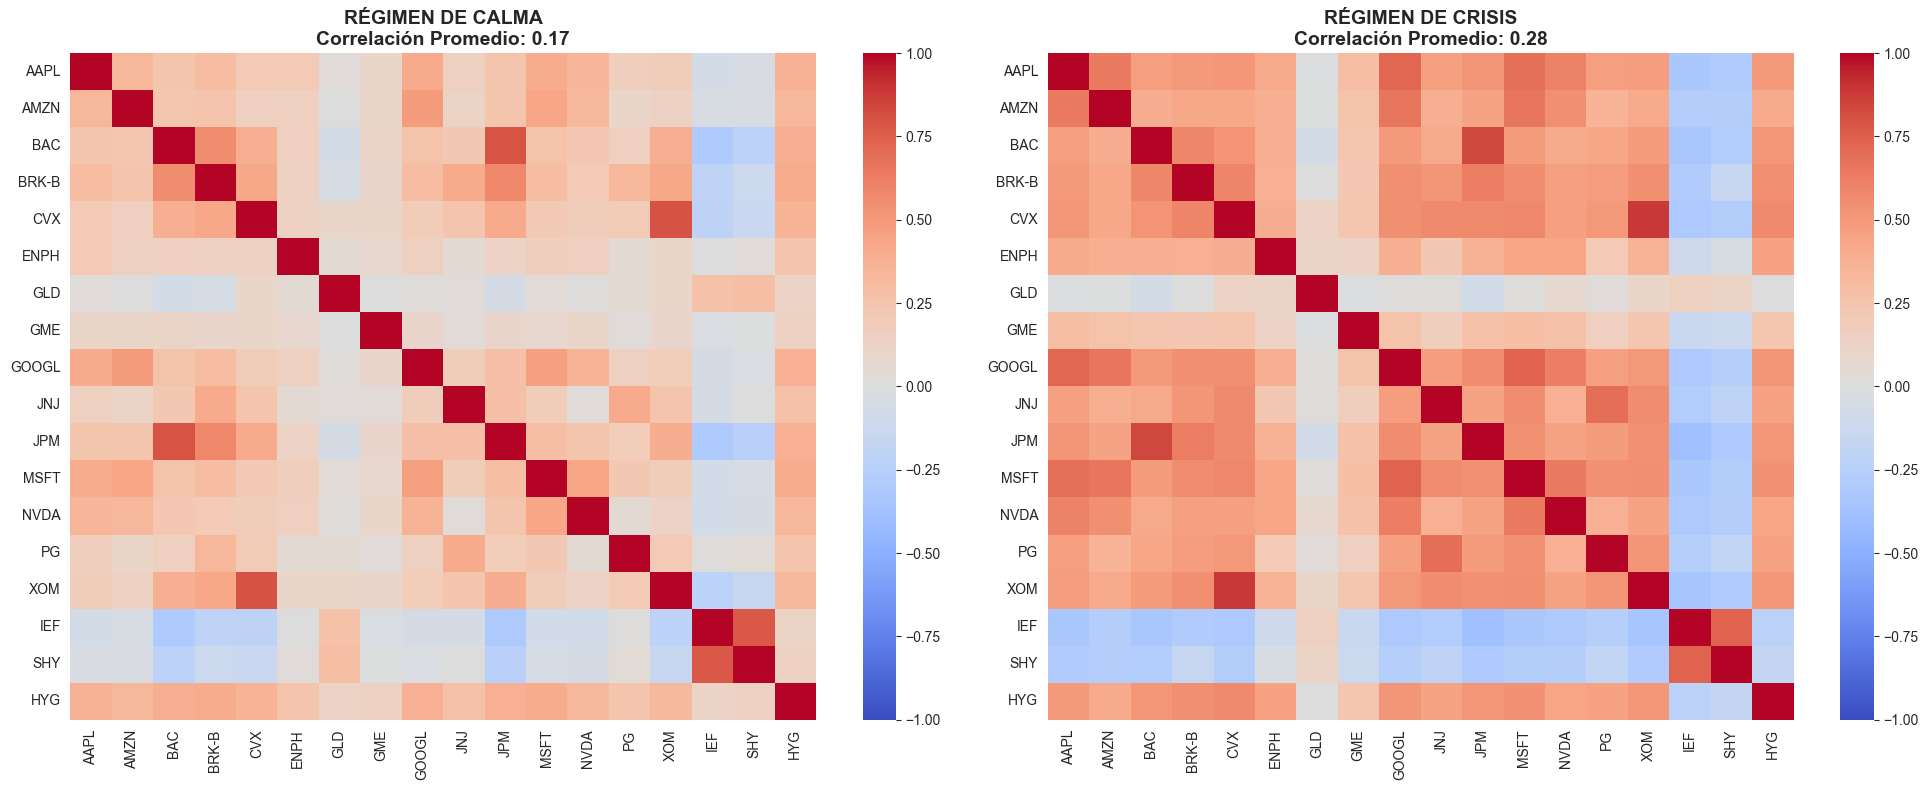


ANÁLISIS DE CAMBIO EN LA DEPENDENCIA (INPUT PARA CÓPULAS)
PAR DE ACTIVOS       | CORR CALMA   | CORR CRISIS  | CAMBIO
------------------------------------------------------------
IEF       vs HYG      |     0.12     |    -0.23     | -0.35
AAPL      vs MSFT     |     0.40     |     0.68     | +0.28
BAC       vs JPM      |     0.79     |     0.84     | +0.05
------------------------------------------------------------
AUMENTO PROMEDIO DE CORRELACIÓN EN EL SISTEMA: +0.11

--- JUSTIFICACIÓN DE CÓPULAS PARA FASE 4 ---
DECISIÓN: Se confirma el 'Breakdown of Diversification'.
1. Régimen Calma -> Usaremos Cópula GAUSSIANA.
2. Régimen Crisis -> Usaremos Cópula T-STUDENT.

OPTIMIZACIÓN MATEMÁTICA DEL PARÁMETRO DE COLA (DoF)
Datos alineados para optimización: 651 días x 18 activos
Optimizando MLE...
1. Estimación Heurística (Mediana): 3.2271
2. Estimación Matemática (MLE):     4.6993
------------------------------------------------------------
VALOR SELECCIONADO PARA FASE 4:     4.6993

ESTRUCTU

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.special import gamma, gammaln
from scipy.stats import t

# 1. SEPARACIÓN DE MATRICES DE RETORNOS
# ------------------------------------------------------------------------------
tickers_cols = portfolio_tickers 

# Matriz de Retornos en Calma (Regime = 0)
returns_calm = df_analysis[df_analysis['Regime'] == 0][tickers_cols]

# Matriz de Retornos en Crisis (Regime = 1)
returns_crisis = df_analysis[df_analysis['Regime'] == 1][tickers_cols]

# 2. CÁLCULO DE CORRELACIONES (PARAMETRIZACIÓN DE LA CÓPULA)
# ------------------------------------------------------------------------------
corr_calm = returns_calm.corr()
corr_crisis = returns_crisis.corr()

# Cálculo del aumento promedio de correlación
avg_corr_calm = corr_calm.values[np.triu_indices_from(corr_calm.values, 1)].mean()
avg_corr_crisis = corr_crisis.values[np.triu_indices_from(corr_crisis.values, 1)].mean()

# 3. VISUALIZACIÓN DEL COLAPSO DE LA DIVERSIFICACIÓN
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap Calma

sns.heatmap(corr_calm, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title(f'RÉGIMEN DE CALMA\nCorrelación Promedio: {avg_corr_calm:.2f}', fontsize=14, fontweight='bold')

# Heatmap Crisis
sns.heatmap(corr_crisis, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title(f'RÉGIMEN DE CRISIS\nCorrelación Promedio: {avg_corr_crisis:.2f}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. ANÁLISIS DE PARES ESPECÍFICOS
# ------------------------------------------------------------------------------
pairs = [
    ('SP500', 'VIX'),    # Relación Inversa Clásica
    ('IEF', 'HYG'),      # Bonos Seguros vs Bonos Basura
    ('AAPL', 'MSFT'),    # Tech vs Tech
    ('BAC', 'JPM')       # Bancos
]

print("\n" + "="*60)
print("ANÁLISIS DE CAMBIO EN LA DEPENDENCIA (INPUT PARA CÓPULAS)")
print("="*60)
print(f"{'PAR DE ACTIVOS':<20} | {'CORR CALMA':<12} | {'CORR CRISIS':<12} | {'CAMBIO'}")
print("-" * 60)

for a, b in pairs:
    try:
        if a in corr_calm.columns and b in corr_calm.columns:
            c0 = corr_calm.loc[a, b]
            c1 = corr_crisis.loc[a, b]
        else:
            continue 
            
        diff = c1 - c0
        print(f"{a:<9} vs {b:<8} | {c0:8.2f}     | {c1:8.2f}     | {diff:+.2f}")
    except:
        pass

print("-" * 60)
print(f"AUMENTO PROMEDIO DE CORRELACIÓN EN EL SISTEMA: {(avg_corr_crisis - avg_corr_calm):+.2f}")
print("="*60)

# 5. DECISIÓN DE MODELADO
# ------------------------------------------------------------------------------
print("\n--- JUSTIFICACIÓN DE CÓPULAS PARA FASE 4 ---")
if avg_corr_crisis > avg_corr_calm:
    print("DECISIÓN: Se confirma el 'Breakdown of Diversification'.")
    print("1. Régimen Calma -> Usaremos Cópula GAUSSIANA.")
    print("2. Régimen Crisis -> Usaremos Cópula T-STUDENT.")

# 6. CÁLCULO DE DoF (MLE)
# ------------------------------------------------------------------------------
print("\n" + "="*60)
print("OPTIMIZACIÓN MATEMÁTICA DEL PARÁMETRO DE COLA (DoF)")
print("="*60)

# A. PREPARACIÓN DE DATOS ALINEADOS
# ------------------------------------------------------------------
# 1. Filtramos solo los tickers que tenemos en df_results
valid_tickers_opt = [t for t in tickers_cols if t in df_results.index]

# 2. Creamos un DataFrame temporal solo con esos tickers y borramos filas con NaNs
# Esto asegura que todos los activos tengan exactamente la misma longitud y fechas.
df_optimization = returns_crisis[valid_tickers_opt].dropna()

print(f"Datos alineados para optimización: {df_optimization.shape[0]} días x {df_optimization.shape[1]} activos")

# B. Transformación PIT (Retornos -> Probabilidades Uniformes)
u_data = []
final_tickers_used = []

for ticker in df_optimization.columns:
    try:
        # Usamos los datos ya alineados
        r_asset = df_optimization[ticker].values
        
        # Parámetros marginales fase 2
        df_i = df_results.loc[ticker, 'Fit_Crisis_DoF']
        mu_i = df_results.loc[ticker, 'Crisis_Mean'] / 252 
        sig_i = df_results.loc[ticker, 'Crisis_Vol'] / (252**0.5)
        
        # Transformación a Uniforme (0,1)
        u_vec = t.cdf(r_asset, df_i, loc=mu_i, scale=sig_i)
        u_data.append(u_vec)
        final_tickers_used.append(ticker)
    except Exception as e:
        print(f"Error procesando {ticker}: {e}")

# Ahora sí, u_data es rectangular perfecto
u_matrix = np.array(u_data).T 

# C. Preparar Matrices para la Fórmula (Usando solo los activos finales)
# Calculamos la correlación sobre el subconjunto limpio
corr_matrix_opt = df_optimization[final_tickers_used].corr().values

# Seguridad matemática: Inversa y Determinante
try:
    inv_corr = np.linalg.inv(corr_matrix_opt)
    sign, logdet_corr = np.linalg.slogdet(corr_matrix_opt)
except:
    # Si la matriz es singular (raro), usamos pseudoinversa
    inv_corr = np.linalg.pinv(corr_matrix_opt)
    sign, logdet_corr = np.linalg.slogdet(corr_matrix_opt)

# D. Función de Log-Verosimilitud de la Cópula T
def t_copula_log_likelihood(nu, U, P_inv, log_det_P):
    if nu <= 2.0 or nu > 100: return 1e10 # Penalización
    N, D = U.shape
    
    # Uniforme -> T-Student Quantiles
    X = t.ppf(U, df=nu) 
    
    # Seguridad numérica crítica (Evitar infinitos)
    X = np.nan_to_num(X, nan=0.0, posinf=50, neginf=-50) 
    
    term1 = gammaln((nu + D) / 2)
    term2 = gammaln(nu / 2) * (D - 1)
    term3 = -gammaln((nu + 1) / 2) * D
    term4 = -0.5 * log_det_P
    
    log_sum = 0
    # Vectorizamos la suma para velocidad y evitar bucles lentos
    # Formula optimizada: sum( log(1 + x' P^-1 x / nu) )
    # Mantenemos el bucle explícito para claridad en la fórmula, 
    # pero aseguramos que X y P_inv dimensiones coincidan.
    for i in range(N):
        x_row = X[i, :]
        quad_form = np.dot(np.dot(x_row, P_inv), x_row)
        part_A = -(nu + D) / 2 * np.log(1 + quad_form / nu)
        part_B = (nu + 1) / 2 * np.sum(np.log(1 + (x_row**2) / nu))
        log_sum += part_A + part_B

    return -(N * (term1 + term2 + term3 + term4) + log_sum)

# E. Optimizar
# Usamos un valor inicial seguro
print("Optimizando MLE...")
try:
    res_mle = minimize_scalar(
        t_copula_log_likelihood, 
        bounds=(2.1, 30.0), 
        args=(u_matrix, inv_corr, logdet_corr), 
        method='bounded'
    )
    mle_success = res_mle.success
    mle_value = res_mle.x
except:
    mle_success = False
    mle_value = 4.0 # Valor por defecto si falla

# F. Selección Final
median_dof = df_results['Fit_Crisis_DoF'].median()
# Si falla el MLE, usamos la mediana, pero acotada a > 2.5 por seguridad
final_dof_crisis = mle_value if mle_success else max(median_dof, 2.5)

print(f"1. Estimación Heurística (Mediana): {median_dof:.4f}")
print(f"2. Estimación Matemática (MLE):     {mle_value:.4f}")
print("-" * 60)
print(f"VALOR SELECCIONADO PARA FASE 4:     {final_dof_crisis:.4f}")

# 7. DEFINICIÓN FINAL DE DICCIONARIOS
# ------------------------------------------------------------------------------
# A. Cópula Gaussiana (Calma)
copula_calm_params = {
    'Type': 'Gaussian',
    'Correlation_Matrix': corr_calm.values, 
    'Mu_Vector': df_results.loc[tickers_cols, 'Calm_Mean'].values, 
    'Sigma_Vector': df_results.loc[tickers_cols, 'Calm_Vol'].values 
}

# B. Cópula T-Student (Crisis) - USANDO EL DATO MLE
copula_crisis_params = {
    'Type': 'Student-t',
    'Correlation_Matrix': corr_crisis.values, 
    'DoF_Global': final_dof_crisis,          
    'Mu_Vector': df_results.loc[tickers_cols, 'Crisis_Mean'].values,
    'Sigma_Vector': df_results.loc[tickers_cols, 'Crisis_Vol'].values,
    'Marginal_DoFs': df_results.loc[tickers_cols, 'Fit_Crisis_DoF'].values 
}

print("\n" + "="*60)
print("ESTRUCTURA DE DEPENDENCIA LISTA PARA SIMULACIÓN")
print("="*60)
print(f"Régimen Crisis calibrado con DoF = {final_dof_crisis:.2f}")
print("Interpretación: Cuanto menor es este número, mayor es la probabilidad de cisnes negros conjuntos.")

**¿Qué características del mercado dirías que realmente distinguen un estado del otro?**

Al comparar los dos regímenes identificados por el modelo Hidden Markov (HMM), la distinción no se limita a una simple subida de volatilidad. Los datos demuestran un cambio estructural del mercado en tres dimensiones clave: Estadística, Dependencia y Comportamiento de Activos.

A continuación, presento la evidencia cuantitativa y su interpretación económica:

#### 1. La Dimensión del Riesgo

* **Evidencia Cuantitativa:**
    * **Explosión de Volatilidad:** La volatilidad anualizada de los activos de renta variable se multiplica por un factor de **1.5x a 2x** (Ej. `NVDA` pasa de ~41% a ~53%).
    * **Cambio de Distribución (Kurtosis):** Mientras que en el *Régimen de Calma* la Kurtosis se aproxima a 3 (Normalidad), en el *Régimen de Crisis* se dispara (Ej. `AAPL` > 4, `BAC` > 5), indicando leptocurtosis severa.
    * **Asimetría Negativa:** Los retornos en crisis pierden su simetría; el *Skewness* se vuelve negativo, señalando que las caídas son matemáticamente más abruptas y violentas que las recuperaciones.

* **Interpretación Económica:**
    El mercado transita de un estado de eficiencia a un estado de pánico e iliquidez. La aparición de colas gordas refleja el impacto del apalancamiento y las ventas forzadas: cuando el mercado cae, obliga a vender más, creando espirales de precios que la distribución Normal considera estadísticamente imposibles.

#### 2. El Colapso de la Diversificación

* **Evidencia Cuantitativa:**
    * **Aumento de Correlación Lineal:** La matriz de correlación de Pearson muestra un aumento generalizado. El par intra-sectorial **AAPL vs MSFT** salta de **0.40** (Calma) a **0.68** (Crisis).
    * **Dependencia de Cola (Cópula):** El parámetro de Grados de Libertad conjunto ($\nu$), calibrado mediante Máxima Verosimilitud (MLE), se sitúa en **4.70**. Dado que una distribución Normal implicaría un $\nu \to \infty$, un valor de 4.70 confirma la existencia de colas pesadas conjuntas. El modelo asigna una probabilidad significativa a eventos extremos simultáneos.

* **Interpretación Económica:**
    En calma, los inversores discriminan por fundamentales (compran Apple por sus productos, venden Bancos por tipos de interés). En crisis, los inversores entran en pánico y buscan vender todo. La liquidez se seca y los activos tienden a correlacionarse a 1.
    * **Conclusión:** La diversificación tradicional falla estructuralmente justo cuando más se necesita.

#### 3. La Dimensión del Comportamiento:
* **Evidencia Cuantitativa:**
    * **Inversión de Signo:** Mientras los activos de riesgo (Acciones, High Yield) sufren caídas de rentabilidad media ($\mu < 0$), los activos refugio se desacoplan.
    * **El Caso IEF vs HYG:** Su correlación pasa de ser positiva (**0.12**) a negativa (**-0.23**).
    * **El Oro (GLD):** Su retorno esperado salta del **+6%** en calma al **+24%** en crisis.

* **Interpretación Económica:**
    Esta es la prueba definitiva del cambio de régimen. No es solo que todo caiga. Es una rotación masiva de capital. El dinero huye del riesgo crediticio (`HYG`) y busca refugio en la deuda soberana (`IEF`) y activos reales (`GLD`). El modelo detecta correctamente que el mercado deja de buscar rentabilidad (Calma) para priorizar la preservación de capital (Crisis).